# <center>Practice 03. Linear Regression</center>
## <center>Part 01. Проблема переобучения</center>

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Для моделей машинного обучения критически важна их обобщающая способность. Если модель смогла выявить закономерность в данных, близкую к истинной, то такая модель сможет показывать хорошие результаты на новых объектах. В противном случае, даже при идеальной работе на обучающей выборке от модели не будет никакой пользы. Такое может произойти, если модель слишком углубилась в обучающую выборку и просто её запомнила. Такая проблема называется переобучением.

Посмотрим на примере степеней признаков при линейной регрессии.

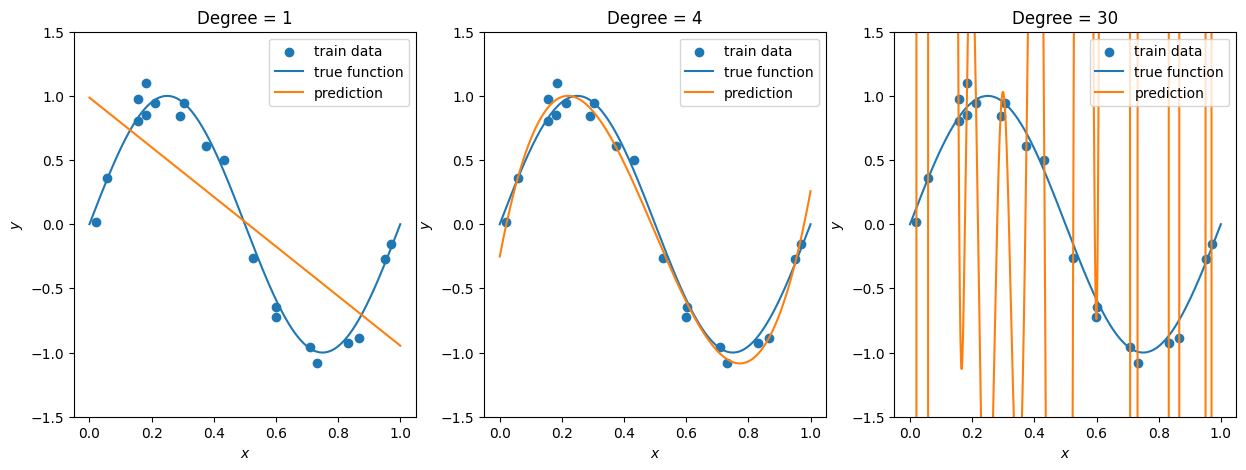

In [8]:
from sklearn.linear_model import LinearRegression

np.random.seed(42)

x_true = np.linspace(0, 1, 1000)  # генеральная совокупность
y_true = np.sin(2*np.pi * x_true)

x_train = np.random.uniform(0, 1, size=20)  # обучающая выборка
y_train = np.sin(2*np.pi * x_train) + np.random.normal(scale=0.1, size=x_train.shape)

from sklearn.preprocessing import PolynomialFeatures

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

for i, degree in enumerate([1, 4, 30]):
    X_train = PolynomialFeatures(degree, include_bias=False).fit_transform(x_train[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x_true[:, None])
    regression = LinearRegression().fit(X_train, y_train)
    y_pred = regression.predict(X)
    axs[i].scatter(x_train, y_train, label="train data")
    axs[i].plot(x_true, y_true, label="true function")
    axs[i].plot(x_true, y_pred, label="prediction")
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$y$")
    axs[i].set_ylim(-1.5, 1.5)
    axs[i].legend()

Бороться с этим можно регуляризацией модели. 

Как связаны переобучение линейной модели и большие веса?

Регуляризация: модель штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{\alpha}(w) = Q(w) + \alpha \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\alpha$ &mdash; коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

Можно ли регулиризовывать $w_0$?

Зачем нужен коэффициент $\alpha$?

## <center>Part 02. Пример данных</center>

Рассмотрим датасет для предсказания стоимости домов, который можно скачать [тут](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

Необходимо решить задачу регрессии и научиться предсказывать целовой признак **SalePrice** –– стоимость дома.

Считываем обучающую выборку.

In [3]:
df = pd.read_csv('../../data/house_price/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df = df.drop(columns=["Id"])
df.shape

(1460, 80)

Разобьём нашу выборку на обучающую и тестовую. Зачем нужен random_state?

In [5]:
from sklearn.model_selection import train_test_split

y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Посмотрим какие значения принимает целевой признак.

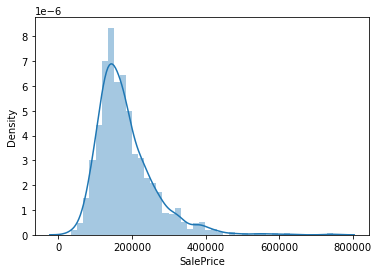

In [6]:
sns.distplot(y_train);

Разберёмся с пропущенными количественными значениями.

In [8]:
numeric_data = X_train.select_dtypes([np.number])
numeric_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_mean)
X_test = X_test.fillna(numeric_mean)

Посмотрим какая есть корреляция между признаками.

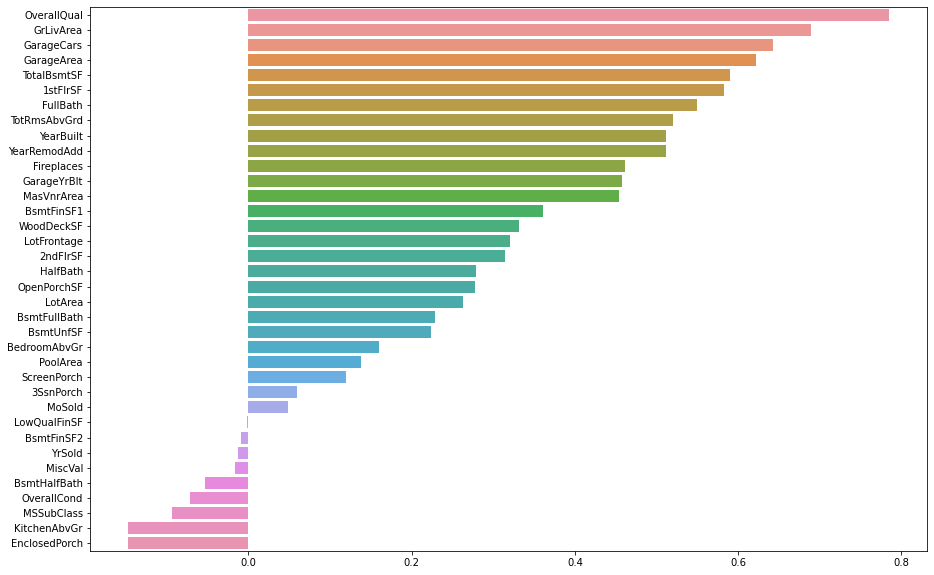

In [9]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

С некоторыми признаками есть сильная линейная зависимость.

## <center>Part 03. Построение модели</center>

Полезные библиотеки:
- sklearn для простых моделей (линейные модели, деревья), 
- XGBoost и др. для ансамбля над деревьями,
- PyTorch, Tensorflow и др. для нейронных сетей.

Для линейной регрессии в sklearn:

- LinearRegression –– линейная регрессия с функцией потерь MSE
- Ridge –– линейная регрессия с функцией потерь MSE и $\ell_2$-регуляризатором
- Lasso — линейная регрессия с функцией потерь MSE и $\ell_1$-регуляризатором

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()  # выбранная модель

model.fit(X_train[numeric_features], y_train)  # обучение модели на обучающей выборке

y_train_pred = model.predict(X_train[numeric_features])  # использование модели для предсказания на обучающей
y_test_pred = model.predict(X_test[numeric_features])  # или на тестовой выборке

print("Test RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 35244.19047321524
Train RMSE = 34575.82106377232


## <center>Part 04. Кросс-валидация, масштабирование</center>

In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 40919.5758
	66498.2746
	33817.2142
	27403.0255
	28143.3824
Mean CV MSE = 39356.2945


Качество модели хорошо бы сравнить. Например, с глупым предсказателем.

In [12]:
stupid_pred = y_train.mean()
print("Test RMSE with stupid predictor =", mean_squared_error(y_test, stupid_pred * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE with stupid predictor =", mean_squared_error(y_train, stupid_pred * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE with stupid predictor = 83545.17795000924
Train RMSE with stupid predictor = 77579.4783941699


Далее, анализируя веса, можно понять какие зависимости нашла модель.

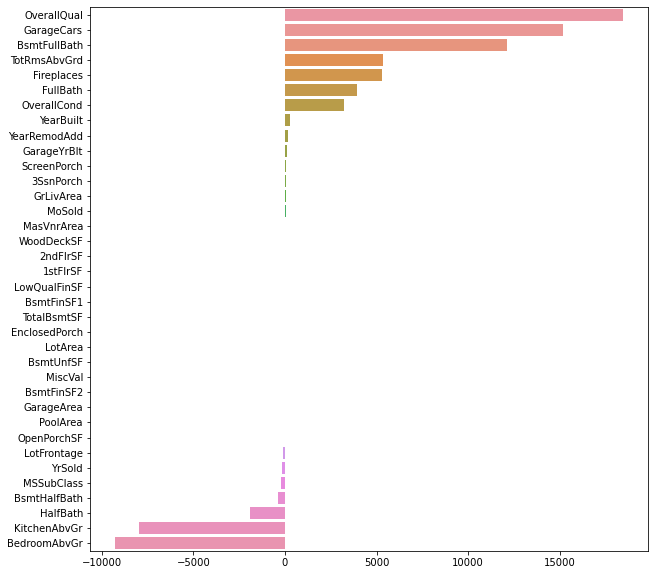

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

sorted_weights = sorted(zip(model.coef_, numeric_features, X_train[numeric_features].std()), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
sns.barplot(y=features, x=weights, ax=ax)
plt.show()

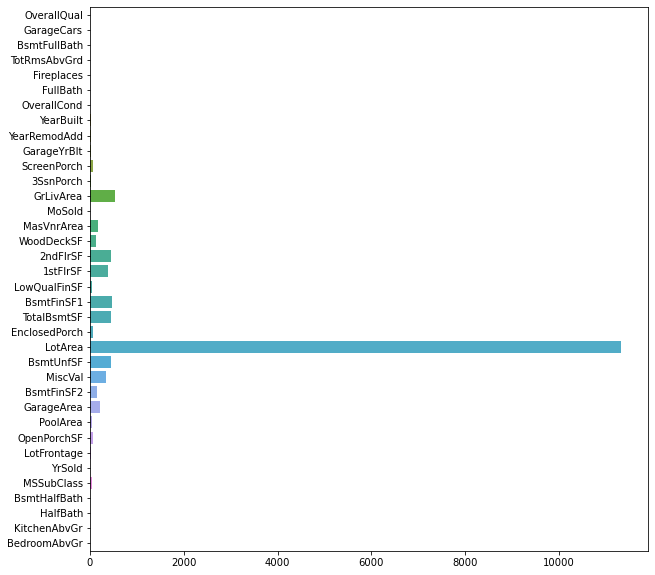

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
scales = [x[2] for x in sorted_weights]
sns.barplot(y=features, x=scales, ax=ax)
plt.show()

Поэтому надо масштабировать признаки перед обучением модели. Для этого воспользуемся трансформером StandardScaler.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 35244.8586
Train RMSE = 34575.7822


Теперь обучение и оценка важности признаков, а также регуляризация стали честнее.

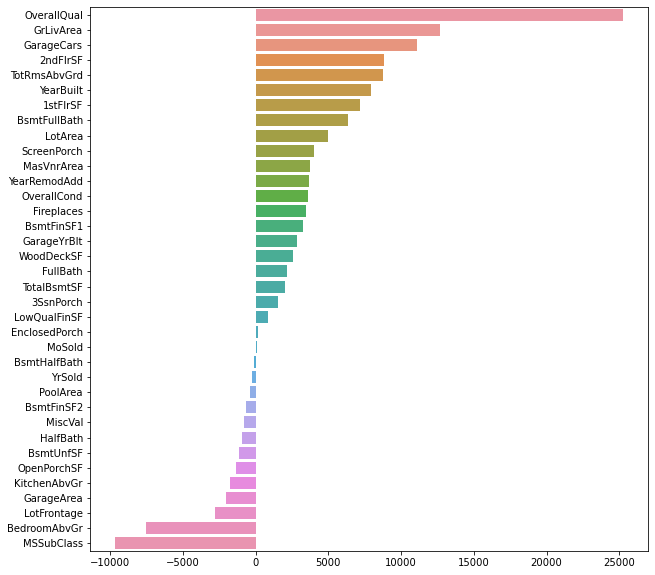

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

sorted_weights = sorted(zip(model.coef_, numeric_features, X_train_scaled.std(axis=0)), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
sns.barplot(y=features, x=weights, ax=ax)
plt.show()

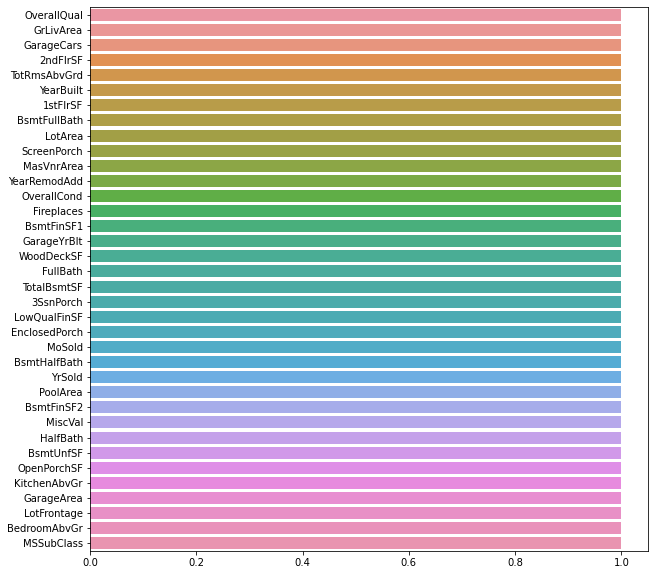

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
scales = [x[2] for x in sorted_weights]
sns.barplot(y=features, x=scales, ax=ax)
plt.show()

## <center>Part 05. Подбор гиперпараметров модели</center>

Подбор обычно идёт по сетке (логарифмической).

Text(0, 0.5, 'CV score')

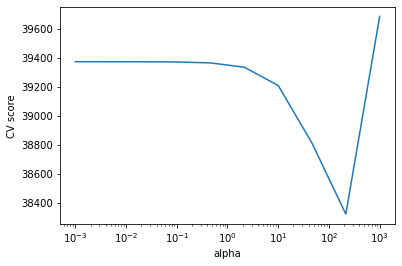

In [18]:
from sklearn.model_selection import GridSearchCV

alpha_grid = np.logspace(-3, 3, 10)
searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid}], scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(X_train_scaled, y_train)

plt.plot(alpha_grid, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Так мы получим наилучшее значение гиперпараметров для выбранной модели.

In [19]:
best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 215.4435


Теперь обучим модель с подобранным гиперпараметром регуляризации. Для удобства можно использовать класс Pipeline который хранит последовательность шагов обучения и помогает вызывать правильные методы для обучающих и тестовых выборок.

In [20]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE =", mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 35455.53805664659
